In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [4]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [7]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# Generator + Discriminator

In [8]:
ginput = Input(shape=(100, ))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_5 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


epoch:0 d_loss:0.4951 g_loss:0.3172
epoch:1 d_loss:0.4741 g_loss:0.4424
epoch:2 d_loss:0.4706 g_loss:0.5612
epoch:3 d_loss:0.5068 g_loss:0.6038
epoch:4 d_loss:0.5157 g_loss:0.6306
epoch:5 d_loss:0.4729 g_loss:0.6275
epoch:6 d_loss:0.4663 g_loss:0.6447
epoch:7 d_loss:0.4649 g_loss:0.7690
epoch:8 d_loss:0.5024 g_loss:0.7423
epoch:9 d_loss:0.5329 g_loss:0.6979
epoch:10 d_loss:0.5153 g_loss:0.8336
epoch:11 d_loss:0.4963 g_loss:0.8332
epoch:12 d_loss:0.4843 g_loss:0.6946
epoch:13 d_loss:0.4032 g_loss:0.7414
epoch:14 d_loss:0.5377 g_loss:0.6551
epoch:15 d_loss:0.4944 g_loss:0.8134
epoch:16 d_loss:0.4510 g_loss:0.7358
epoch:17 d_loss:0.4993 g_loss:0.7061
epoch:18 d_loss:0.5304 g_loss:0.6241
epoch:19 d_loss:0.4750 g_loss:0.6766
epoch:20 d_loss:0.4548 g_loss:0.7340
epoch:21 d_loss:0.3888 g_loss:0.8532
epoch:22 d_loss:0.4076 g_loss:0.7615
epoch:23 d_loss:0.4057 g_loss:0.6307
epoch:24 d_loss:0.4237 g_loss:0.5422
epoch:25 d_loss:0.3982 g_loss:0.6575
epoch:26 d_loss:0.4332 g_loss:0.6936
epoch:27 d_

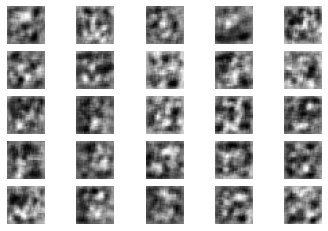

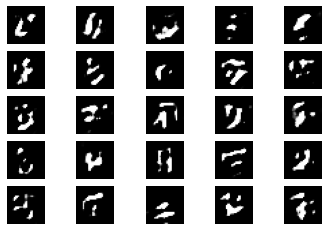

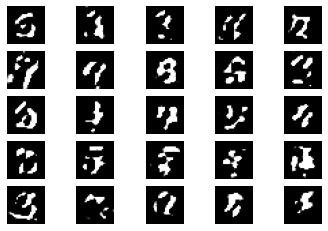

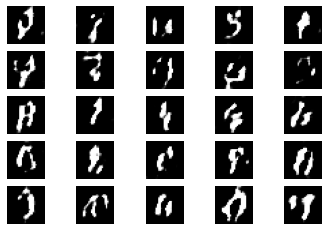

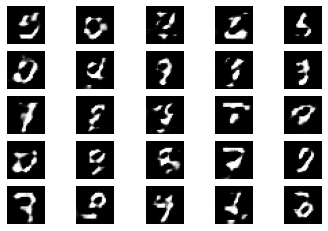

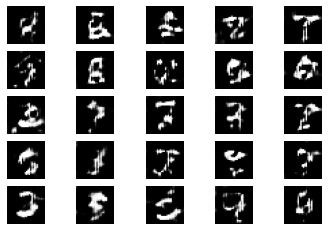

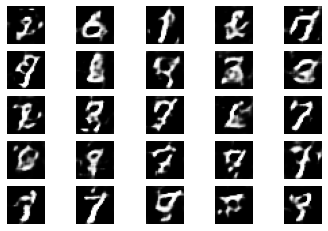

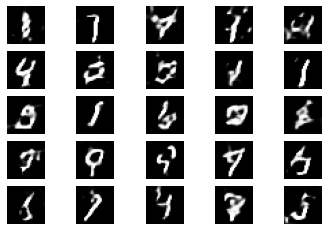

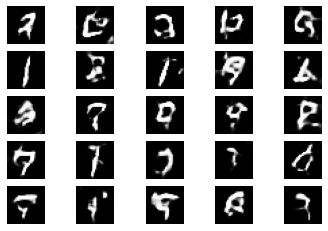

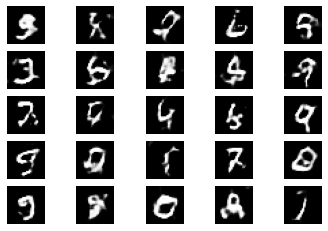

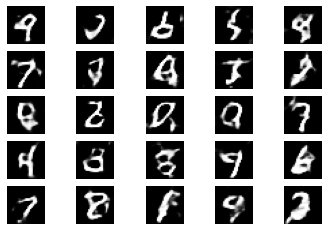

In [20]:
def gan_train(epoch, batch_size, saving_interval):
  (X_train, _), (_,_) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

  X_train = (X_train - 127.5) / 127.5

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)
    noise = np.random.normal(0,1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise,true)

    print('epoch:%d' %i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)

    if i % saving_interval == 0:
      noise = np.random.normal(0,1,(25,100))
      gen_imgs = generator.predict(noise)
      
      gen_imgs = 0.5 * gen_imgs +0.5
      fig, axs = plt.subplots(5,5)
      count =0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1

      fig.savefig('gan_images/gan_mnist_%d.png' %i)

gan_train(2001, 32, 200)